In [25]:
# ============================================================
# ENHANCED SSL TRAINING WITH AGGRESSIVE OPTIMIZATION
# Implements: Focal Loss tuning, threshold optimization,
# architecture improvements, training strategies, and ensemble capability
# ============================================================

In [26]:
# ============================================================
# 1. Import Required Libraries, Modules, and Packages
# ============================================================
import os
import sys
from pathlib import Path
import json
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
from PIL import Image
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from tqdm import tqdm
import timm
import warnings
warnings.filterwarnings('ignore')


In [27]:
# ============================================================
# 2. Setup and Seeds
# ============================================================
# Change working dir if running inside notebook folder structure
if 'notebook' in os.getcwd():
    os.chdir('../')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# global device variable
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [28]:
# ============================================================
# 3. ENHANCED MODEL ARCHITECTURE with Attention
# ============================================================
class EnhancedSSLEfficientNet(nn.Module):
    def __init__(self, model_name='efficientnet_b0', num_classes=2, dropout_rate=0.4):
        super(EnhancedSSLEfficientNet, self).__init__()
        # backbone from timm with no classifier
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0)
        self.feature_dim = self.backbone.num_features

        # Attention mechanism implemented as small MLP
        self.attention = nn.Sequential(
            nn.Linear(self.feature_dim, max(1, self.feature_dim // 4)),
            nn.ReLU(inplace=True),
            nn.Linear(max(1, self.feature_dim // 4), self.feature_dim),
            nn.Sigmoid()
        )

        # Deeper classifier with batch normalization as in original code
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.6),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate * 0.4),
            nn.Linear(256, num_classes)
        )

        # Projector for SSL if needed
        self.projector = nn.Sequential(
            nn.Linear(self.feature_dim, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 64)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in [self.attention, self.classifier, self.projector]:
            for layer in m:
                if isinstance(layer, nn.Linear):
                    nn.init.xavier_uniform_(layer.weight)
                    if layer.bias is not None:
                        nn.init.constant_(layer.bias, 0)

    def forward(self, x):
        features = self.backbone(x)  # shape [B, feature_dim]
        attention_weights = self.attention(features)  # shape [B, feature_dim]
        features = features * attention_weights
        return self.classifier(features)


In [29]:
# ============================================================
# 4. ENHANCED FOCAL LOSS (Recommendation #2)
# ============================================================
class AggressiveFocalLoss(nn.Module):
    """Enhanced focal loss with higher alpha and gamma for sensitivity"""
    def __init__(self, alpha=0.95, gamma=3.0):
        super(AggressiveFocalLoss, self).__init__()
        # class weighting vector for two classes
        self.alpha = torch.tensor([1 - alpha, alpha])
        self.gamma = gamma

    def forward(self, inputs, targets):
        # inputs are logits
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        targets = targets.type(torch.long)
        at = self.alpha.gather(0, targets.data.view(-1)).to(inputs.device)
        pt = torch.exp(-BCE_loss)
        F_loss = at * (1 - pt)**self.gamma * BCE_loss
        return F_loss.mean()

In [30]:
# ============================================================
# 5. AGGRESSIVE DATA AUGMENTATION (Recommendation #2)
# ============================================================
norm_params = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}

# Very strong augmentation for positives
very_strong_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.6),
    transforms.RandomVerticalFlip(p=0.6),
    transforms.RandomRotation(degrees=45),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.3, hue=0.15),
    transforms.RandomAffine(degrees=30, translate=(0.15, 0.15), scale=(0.7, 1.3)),
    transforms.RandomPerspective(distortion_scale=0.3, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(**norm_params)
])

moderate_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(**norm_params)
])

weak_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(**norm_params)
])

val_transform = weak_transform

In [31]:
# ============================================================
# 6. Datasets
# ============================================================
class LabeledDataset(Dataset):
    def __init__(self, paths, labels, transform_map):
        self.paths, self.labels, self.tm = paths, labels, transform_map
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        label = self.labels[idx]
        return self.tm[label](img), label

class UnlabeledDataset(Dataset):
    def __init__(self, paths, weak_tf, strong_tf):
        self.paths, self.weak_tf, self.strong_tf = paths, weak_tf, strong_tf
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        return self.weak_tf(img), self.strong_tf(img)

class ValidationDataset(Dataset):
    def __init__(self, paths, labels, transform):
        self.paths, self.labels, self.tf = paths, labels, transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert('RGB')
        return self.tf(img), self.labels[idx]

In [ ]:
# ============================================================
# 7. Data Loading
# ============================================================
def load_and_prepare_data():
    ARTIFACTS_DIR = Path("artifacts")
    with open(ARTIFACTS_DIR / "data_metadata.json", "r") as f:
        data_metadata = json.load(f)
    data_dir = Path(data_metadata["data_dir"])
    labeled_dir, unlabeled_dir = data_dir / "labeled", data_dir / "unlabeled"

    labeled_paths, labels = [], []
    for name, idx in {"Negative": 0, "Positive": 1}.items():
        class_dir = labeled_dir / name
        if class_dir.exists():
            for path in class_dir.glob("*.[jp][pn]g"):
                labeled_paths.append(str(path))
                labels.append(idx)

    unlabeled_paths = [str(p) for p in unlabeled_dir.glob("*.[jp][pn]g")] if unlabeled_dir.exists() else []
    print(f"Loaded {len(labeled_paths)} labeled ({Counter(labels)}) and {len(unlabeled_paths)} unlabeled images.")

    train_paths, val_paths, train_labels, val_labels = train_test_split(
        labeled_paths, labels, test_size=0.2, random_state=SEED, stratify=labels
    )

    train_dataset = LabeledDataset(train_paths, train_labels,
                                   transform_map={0: moderate_transform, 1: very_strong_transform})
    val_dataset = ValidationDataset(val_paths, val_labels, val_transform)
    unlabeled_dataset = UnlabeledDataset(unlabeled_paths, weak_transform, very_strong_transform)

    return train_dataset, val_dataset, unlabeled_dataset, train_labels

# helper to build DataLoaders explicitly for reuse
def build_loaders(batch_size_labeled=16, batch_size_unlabeled=32):
    train_dataset, val_dataset, unlabeled_dataset, train_labels = load_and_prepare_data()
    class_counts = np.bincount(train_labels)
    class_weights = 1.0 / class_counts
    sample_weights = np.array([class_weights[label] for label in train_labels])
    sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

    labeled_loader = DataLoader(train_dataset, batch_size=batch_size_labeled, sampler=sampler)
    val_loader = DataLoader(val_dataset, batch_size=batch_size_labeled, shuffle=False)
    unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=batch_size_unlabeled, shuffle=True)

    return labeled_loader, val_loader, unlabeled_loader 

In [33]:
# ============================================================
# 8. ENHANCED TRAINER with Better Threshold Search (Recommendation #3)
# ============================================================
class EnhancedTrainer:
    def __init__(self, model, device='cuda', ssl_weight=0.5, confidence_thresh=0.97):
        self.model, self.device = model.to(device), device
        self.criterion = AggressiveFocalLoss(alpha=0.95, gamma=3.0)
        self.ssl_weight, self.confidence_thresh = ssl_weight, confidence_thresh

        self.optimizer = torch.optim.AdamW(
            self.model.parameters(), lr=1e-5, weight_decay=1e-2
        )

        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer, T_0=10, T_mult=2
        )

        self.history = {
            'train_loss': [], 'consistency_loss': [],
            'sensitivity': [], 'specificity': [],
            'false_negatives': [], 'false_positives': []
        }
        self.best_clinical_score = float('inf')
        self.best_metrics = {}

    def train_epoch(self, labeled_loader, unlabeled_loader, epoch, warmup_epochs):
        self.model.train()
        total_sup_loss, total_cons_loss = 0, 0
        unlabeled_iter = iter(unlabeled_loader)
        pbar = tqdm(labeled_loader, desc=f'Epoch {epoch+1}')

        for labeled_images, labels in pbar:
            labeled_images, labels = labeled_images.to(self.device), labels.to(self.device)
            logits_l = self.model(labeled_images)
            sup_loss = self.criterion(logits_l, labels)
            total_loss = sup_loss

            if epoch >= warmup_epochs:
                try:
                    images_u_w, images_u_s = next(unlabeled_iter)
                except StopIteration:
                    unlabeled_iter = iter(unlabeled_loader)
                    images_u_w, images_u_s = next(unlabeled_iter)
                images_u_w, images_u_s = images_u_w.to(self.device), images_u_s.to(self.device)

                with torch.no_grad():
                    logits_u_w = self.model(images_u_w)
                    max_probs, p_targets = torch.max(F.softmax(logits_u_w, dim=1), dim=1)
                    mask = max_probs.ge(self.confidence_thresh).float()

                logits_u_s = self.model(images_u_s)
                cons_loss = (F.cross_entropy(logits_u_s, p_targets, reduction='none') * mask).mean()
                total_loss += self.ssl_weight * cons_loss
                total_cons_loss += cons_loss.item()

            self.optimizer.zero_grad()
            total_loss.backward()
            self.optimizer.step()
            total_sup_loss += sup_loss.item()
            pbar.set_postfix({'sup_loss': f'{sup_loss.item():.3f}',
                              'cons_loss': f'{total_cons_loss / (len(pbar) or 1):.3f}'})

        return total_sup_loss / len(labeled_loader), total_cons_loss / len(labeled_loader)

    def validate_and_find_threshold(self, val_loader, fn_target=2, fp_target=3):
        self.model.eval()
        all_probs, all_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                logits = self.model(images.to(self.device))
                all_probs.extend(F.softmax(logits, dim=1)[:, 1].cpu().numpy())
                all_labels.extend(labels.numpy())
        all_probs, all_labels = np.array(all_probs), np.array(all_labels)

        best_threshold = -1
        best_fp = float('inf')

        fn_acceptable_thresholds = []
        for threshold in np.arange(0.01, 0.95, 0.005):
            preds = (all_probs > threshold).astype(int)
            fn = np.sum((all_labels == 1) & (preds == 0))
            if fn <= fn_target:
                fn_acceptable_thresholds.append((threshold, fn))

        if fn_acceptable_thresholds:
            for threshold, fn in fn_acceptable_thresholds:
                preds = (all_probs > threshold).astype(int)
                fp = np.sum((all_labels == 0) & (preds == 1))
                if fp <= fp_target and fp < best_fp:
                    best_fp = fp
                    best_threshold = threshold

        if best_threshold == -1 and fn_acceptable_thresholds:
            for threshold, fn in fn_acceptable_thresholds:
                preds = (all_probs > threshold).astype(int)
                fp = np.sum((all_labels == 0) & (preds == 1))
                if fp < best_fp:
                    best_fp = fp
                    best_threshold = threshold

        if best_threshold == -1:
            best_fn = float('inf')
            for threshold in np.arange(0.01, 0.95, 0.005):
                preds = (all_probs > threshold).astype(int)
                fn = np.sum((all_labels == 1) & (preds == 0))
                fp = np.sum((all_labels == 0) & (preds == 1))
                if fn < best_fn or (fn == best_fn and fp < best_fp):
                    best_fn, best_fp, best_threshold = fn, fp, threshold

        y_pred = (all_probs >= best_threshold).astype(int)
        tp = np.sum((all_labels == 1) & (y_pred == 1))
        fn_final = np.sum((all_labels == 1) & (y_pred == 0))
        tn = np.sum((all_labels == 0) & (y_pred == 0))
        fp_final = np.sum((all_labels == 0) & (y_pred == 1))

        metrics = {
            'sensitivity': tp/(tp+fn_final) if tp+fn_final>0 else 0,
            'specificity': tn/(tn+fp_final) if tn+fp_final>0 else 0,
            'false_negatives': fn_final,
            'false_positives': fp_final
        }
        return metrics, best_threshold

    def train(self, labeled_loader, unlabeled_loader, val_loader, epochs=60, warmup_epochs=5):
        print("\n" + "="*60)
        print("ENHANCED SSL TRAINING WITH AGGRESSIVE OPTIMIZATION")
        print("="*60)
        patience, max_patience = 0, 20

        for epoch in range(epochs):
            train_loss, cons_loss = self.train_epoch(labeled_loader, unlabeled_loader, epoch, warmup_epochs)
            metrics, threshold = self.validate_and_find_threshold(val_loader, fn_target=2, fp_target=3)

            fn, fp = metrics['false_negatives'], metrics['false_positives']
            current_score = (fn * 5) + fp

            self.scheduler.step()

            for key, value in metrics.items():
                self.history[key].append(value)
            self.history['train_loss'].append(train_loss)
            self.history['consistency_loss'].append(cons_loss)

            print(f"\nEpoch {epoch+1}/{epochs} | Sens: {metrics['sensitivity']:.3f}, "
                  f"Spec: {metrics['specificity']:.3f}, FN: {fn}, FP: {fp}, Thr: {threshold:.3f}")

            is_clinically_acceptable = fn <= 2 and fp <= 3
            is_best = False

            if is_clinically_acceptable:
                if not self.best_metrics.get('is_clinically_acceptable', False) or current_score < self.best_clinical_score:
                    is_best = True
            elif not self.best_metrics.get('is_clinically_acceptable', False) and current_score < self.best_clinical_score:
                is_best = True

            if is_best:
                self.best_clinical_score = current_score
                self.best_metrics = {**metrics, 'is_clinically_acceptable': is_clinically_acceptable}
                patience = 0
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'metrics': metrics,
                    'threshold': threshold,
                    'history': self.history
                }
                torch.save(checkpoint, 'artifacts/enhanced_model.pth')
                print(f"  ✓ Saved best model (FN: {fn}, FP: {fp}, Score: {current_score})")
            else:
                patience += 1

            if (patience >= max_patience and epoch > 15) or (self.best_metrics.get('is_clinically_acceptable', False) and epoch > 15):
                print(f"\n{'✓ CLINICAL TARGET MET' if self.best_metrics.get('is_clinically_acceptable', False) else 'Early stopping'}!")
                break

        print("\n" + "="*60)
        print("TRAINING COMPLETED")
        print(f"Best Results: {self.best_metrics}")
        print("="*60)
        return self.history

In [34]:
# ============================================================
# 9. ENSEMBLE TRAINING
# ============================================================
def train_ensemble(n_models=3):
    """Train multiple models with different seeds for ensemble"""
    models = []
    trainers = []

    for i in range(n_models):
        print(f"\n{'='*60}")
        print(f"TRAINING ENSEMBLE MODEL {i+1}/{n_models}")
        print(f"{'='*60}\n")

        seed = SEED + i * 100
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

        # Create fresh data loaders
        labeled_loader, val_loader, unlabeled_loader = build_loaders(batch_size_labeled=16, batch_size_unlabeled=32)

        # Create and train model
        device_local = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = EnhancedSSLEfficientNet(num_classes=2, dropout_rate=0.4)

        # Load pretrained weights robustly if available
        pretrained_path = Path("artifacts/ssl_model_best_010_78.9.pth")
        if pretrained_path.exists():
            checkpoint = torch.load(pretrained_path, map_location=device_local)
            state_dict_ckpt = checkpoint.get('model_state_dict', checkpoint)

            model_sd = model.state_dict()
            for k in list(state_dict_ckpt.keys()):
                if k in model_sd:
                    if state_dict_ckpt[k].shape != model_sd[k].shape:
                        print(f"Skipping key {k}, checkpoint shape {state_dict_ckpt[k].shape}, model shape {model_sd[k].shape}")
                        del state_dict_ckpt[k]
                else:
                    del state_dict_ckpt[k]

            model.load_state_dict(state_dict_ckpt, strict=False)

        trainer = EnhancedTrainer(model, device=device_local, ssl_weight=0.5, confidence_thresh=0.97)
        history = trainer.train(labeled_loader, unlabeled_loader, val_loader, epochs=60, warmup_epochs=5)

        # Save training history plot for each ensemble member
        plot_training_history(history, filename=f"ensemble_model_{i}_history.png")

        models.append(model)
        trainers.append(trainer)

        # Save individual model checkpoint and metrics
        torch.save({
            'model_state_dict': model.state_dict(),
            'metrics': trainer.best_metrics
        }, f'artifacts/enhanced_model_ensemble_{i}.pth')

    return models, trainers

# Smarter ensemble helpers included here to keep related logic together
def plot_confusion_matrix(y_true, preds, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Neg", "Pos"], yticklabels=["Neg", "Pos"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

def evaluate_model_predictions(y_true, preds, probs, title="Model"):
    report = classification_report(y_true, preds, output_dict=True, zero_division=0)
    sensitivity = report["1"]["recall"]
    specificity = report["0"]["recall"]
    precision = report["1"]["precision"]
    accuracy = report["accuracy"]
    auc = roc_auc_score(y_true, probs[:, 1]) if probs is not None else float("nan")

    plot_confusion_matrix(y_true, preds, title=f"{title} - Confusion Matrix")

    print(f"\n📊 Performance for {title}:")
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Sensitivity (Recall): {sensitivity:.3f}")
    print(f"Specificity: {specificity:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"AUC: {auc:.3f}")

    return {
        "accuracy": accuracy,
        "sensitivity": sensitivity,
        "specificity": specificity,
        "precision": precision,
        "auc": auc
    }

def smarter_ensemble(models, val_loader, device, weights=None, threshold=0.5, return_probs=True):
    """
    Compute weighted ensemble probabilities for models and apply a passed threshold.
    Returns preds and final_probs if return_probs True.
    """
    all_probs = []
    for model in models:
        model.eval()
        probs = []
        with torch.no_grad():
            for x, _ in val_loader:
                x = x.to(device)
                outputs = model(x)
                if outputs.dim() == 1 or outputs.shape[1] == 1:
                    probs_batch = torch.stack([
                        1 - torch.sigmoid(outputs).unsqueeze(1),
                        torch.sigmoid(outputs).unsqueeze(1)
                    ], dim=1).squeeze(2)
                else:
                    probs_batch = torch.softmax(outputs, dim=1)
                probs.append(probs_batch.cpu())
        probs = torch.cat(probs, dim=0)
        all_probs.append(probs)

    if weights is None:
        weights = [1.0 / len(all_probs)] * len(all_probs)
    final_probs = sum(w * p for w, p in zip(weights, all_probs))
    preds = (final_probs[:, 1] >= threshold).long()

    if return_probs:
        return preds, final_probs
    else:
        return preds

In [35]:
# ============================================================
# 10. Visualization
# ============================================================
def plot_training_history(history, filename='enhanced_training_history.png'):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle('Enhanced SSL Training Progress', fontsize=16, fontweight='bold')

    axes[0, 0].plot(history['train_loss'], label='Supervised Loss')
    axes[0, 0].plot(history['consistency_loss'], label='Consistency Loss', linestyle='--')
    axes[0, 0].set_title('Training Loss Components')
    axes[0, 0].legend()

    axes[0, 1].plot(history['sensitivity'], label='Sensitivity', color='g')
    axes[0, 1].plot(history['specificity'], label='Specificity', color='b')
    axes[0, 1].axhline(y=0.90, color='g', linestyle=':', alpha=0.5, label='Target Sens (0.90)')
    axes[0, 1].axhline(y=0.85, color='b', linestyle=':', alpha=0.5, label='Target Spec (0.85)')
    axes[0, 1].set_title('Sensitivity vs Specificity')
    axes[0, 1].legend()

    axes[1, 0].plot(history['false_negatives'], label='False Negatives', color='r', marker='o')
    axes[1, 0].axhline(y=2, color='r', linestyle=':', alpha=0.5, label='Target (<=2)')
    axes[1, 0].set_title('False Negatives per Epoch')
    axes[1, 0].legend()

    axes[1, 1].plot(history['false_positives'], label='False Positives', color='orange', marker='s')
    axes[1, 1].axhline(y=3, color='orange', linestyle=':', alpha=0.5, label='Target (<=3)')
    axes[1, 1].set_title('False Positives per Epoch')
    axes[1, 1].legend()

    for ax in axes.flat:
        ax.set_xlabel('Epoch')
        ax.grid(True, alpha=0.3)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'artifacts/{filename}', dpi=150)
    plt.show()

def load_saved_winner(load_path="best_model.pth", model_class=None, device=device):
    """
    If model_class provided and checkpoint contains a single model_state_dict,
    load into model_class and return (model, threshold, metrics).
    If checkpoint contains ensemble dict, return raw checkpoint dict.
    """
    p = Path(load_path)
    if not p.exists():
        raise FileNotFoundError(f"{load_path} not found")

    ckpt = torch.load(load_path, map_location=device)

    # single model saved format
    if isinstance(ckpt, dict) and "model_state_dict" in ckpt and "model1_state_dict" not in ckpt:
        if model_class is None:
            raise ValueError("model_class must be provided to load a single-model checkpoint")
        model = model_class()
        model.load_state_dict(ckpt["model_state_dict"])
        model.to(device)
        model.eval()
        return model, ckpt.get("threshold", 0.5), ckpt.get("metrics", {})

    # ensemble checkpoint or raw dict
    return ckpt


TRAINING ENSEMBLE MODEL 1/3

Loaded 190 labeled (Counter({1: 98, 0: 92})) and 6377 unlabeled images.
Skipping key classifier.1.weight, checkpoint shape torch.Size([256, 1280]), model shape torch.Size([512, 1280])
Skipping key classifier.1.bias, checkpoint shape torch.Size([256]), model shape torch.Size([512])

ENHANCED SSL TRAINING WITH AGGRESSIVE OPTIMIZATION


Epoch 1: 100%|██████████| 10/10 [00:43<00:00,  4.35s/it, sup_loss=0.445, cons_loss=0.000]



Epoch 1/60 | Sens: 0.950, Spec: 0.278, FN: 1, FP: 13, Thr: 0.415
  ✓ Saved best model (FN: 1, FP: 13, Score: 18)


Epoch 2: 100%|██████████| 10/10 [00:40<00:00,  4.08s/it, sup_loss=0.189, cons_loss=0.000]



Epoch 2/60 | Sens: 0.900, Spec: 0.389, FN: 2, FP: 11, Thr: 0.380


Epoch 3: 100%|██████████| 10/10 [00:41<00:00,  4.17s/it, sup_loss=0.138, cons_loss=0.000]



Epoch 3/60 | Sens: 0.900, Spec: 0.444, FN: 2, FP: 10, Thr: 0.310


Epoch 4: 100%|██████████| 10/10 [00:38<00:00,  3.81s/it, sup_loss=0.095, cons_loss=0.000]



Epoch 4/60 | Sens: 0.950, Spec: 0.389, FN: 1, FP: 11, Thr: 0.215
  ✓ Saved best model (FN: 1, FP: 11, Score: 16)


Epoch 5: 100%|██████████| 10/10 [00:42<00:00,  4.28s/it, sup_loss=0.137, cons_loss=0.000]



Epoch 5/60 | Sens: 0.900, Spec: 0.389, FN: 2, FP: 11, Thr: 0.250


Epoch 6: 100%|██████████| 10/10 [02:12<00:00, 13.27s/it, sup_loss=0.445, cons_loss=0.019]



Epoch 6/60 | Sens: 0.900, Spec: 0.111, FN: 2, FP: 16, Thr: 0.105


Epoch 7: 100%|██████████| 10/10 [02:11<00:00, 13.16s/it, sup_loss=0.443, cons_loss=0.040]



Epoch 7/60 | Sens: 0.950, Spec: 0.056, FN: 1, FP: 17, Thr: 0.095


Epoch 8: 100%|██████████| 10/10 [02:12<00:00, 13.28s/it, sup_loss=0.008, cons_loss=0.018]



Epoch 8/60 | Sens: 0.900, Spec: 0.056, FN: 2, FP: 17, Thr: 0.075


Epoch 9: 100%|██████████| 10/10 [02:11<00:00, 13.18s/it, sup_loss=0.120, cons_loss=0.009]



Epoch 9/60 | Sens: 0.900, Spec: 0.056, FN: 2, FP: 17, Thr: 0.085


Epoch 10: 100%|██████████| 10/10 [02:19<00:00, 13.97s/it, sup_loss=0.148, cons_loss=0.018]



Epoch 10/60 | Sens: 0.950, Spec: 0.111, FN: 1, FP: 16, Thr: 0.100


Epoch 11: 100%|██████████| 10/10 [02:11<00:00, 13.11s/it, sup_loss=0.081, cons_loss=0.044]



Epoch 11/60 | Sens: 0.900, Spec: 0.056, FN: 2, FP: 17, Thr: 0.080


Epoch 12: 100%|██████████| 10/10 [02:09<00:00, 13.00s/it, sup_loss=0.010, cons_loss=0.021]



Epoch 12/60 | Sens: 0.950, Spec: 0.056, FN: 1, FP: 17, Thr: 0.050


Epoch 13: 100%|██████████| 10/10 [02:19<00:00, 13.93s/it, sup_loss=0.062, cons_loss=0.018]



Epoch 13/60 | Sens: 0.900, Spec: 0.167, FN: 2, FP: 15, Thr: 0.070


Epoch 14: 100%|██████████| 10/10 [02:26<00:00, 14.62s/it, sup_loss=0.695, cons_loss=0.019]



Epoch 14/60 | Sens: 1.000, Spec: 0.000, FN: 0, FP: 18, Thr: 0.010


Epoch 15: 100%|██████████| 10/10 [02:17<00:00, 13.74s/it, sup_loss=0.105, cons_loss=0.035]



Epoch 15/60 | Sens: 0.950, Spec: 0.056, FN: 1, FP: 17, Thr: 0.035


Epoch 16: 100%|██████████| 10/10 [02:03<00:00, 12.36s/it, sup_loss=0.031, cons_loss=0.019]



Epoch 16/60 | Sens: 0.900, Spec: 0.222, FN: 2, FP: 14, Thr: 0.050


Epoch 17: 100%|██████████| 10/10 [01:58<00:00, 11.85s/it, sup_loss=0.174, cons_loss=0.019]



Epoch 17/60 | Sens: 0.950, Spec: 0.111, FN: 1, FP: 16, Thr: 0.030


Epoch 18: 100%|██████████| 10/10 [01:58<00:00, 11.85s/it, sup_loss=0.039, cons_loss=0.043]



Epoch 18/60 | Sens: 0.950, Spec: 0.000, FN: 1, FP: 18, Thr: 0.010


Epoch 19: 100%|██████████| 10/10 [01:59<00:00, 11.91s/it, sup_loss=0.002, cons_loss=0.029]



Epoch 19/60 | Sens: 0.900, Spec: 0.167, FN: 2, FP: 15, Thr: 0.045


Epoch 20: 100%|██████████| 10/10 [02:00<00:00, 12.08s/it, sup_loss=0.135, cons_loss=0.041]



Epoch 20/60 | Sens: 0.900, Spec: 0.278, FN: 2, FP: 13, Thr: 0.045


Epoch 21: 100%|██████████| 10/10 [02:11<00:00, 13.17s/it, sup_loss=0.094, cons_loss=0.029]



Epoch 21/60 | Sens: 0.950, Spec: 0.056, FN: 1, FP: 17, Thr: 0.020


Epoch 22: 100%|██████████| 10/10 [02:05<00:00, 12.56s/it, sup_loss=0.043, cons_loss=0.024]



Epoch 22/60 | Sens: 0.900, Spec: 0.222, FN: 2, FP: 14, Thr: 0.040


Epoch 23: 100%|██████████| 10/10 [02:11<00:00, 13.10s/it, sup_loss=0.056, cons_loss=0.036]



Epoch 23/60 | Sens: 0.900, Spec: 0.111, FN: 2, FP: 16, Thr: 0.035


Epoch 24: 100%|██████████| 10/10 [02:01<00:00, 12.18s/it, sup_loss=0.030, cons_loss=0.043]



Epoch 24/60 | Sens: 0.950, Spec: 0.056, FN: 1, FP: 17, Thr: 0.020

Early stopping!

TRAINING COMPLETED
Best Results: {'sensitivity': np.float64(0.95), 'specificity': np.float64(0.3888888888888889), 'false_negatives': np.int64(1), 'false_positives': np.int64(11), 'is_clinically_acceptable': np.False_}


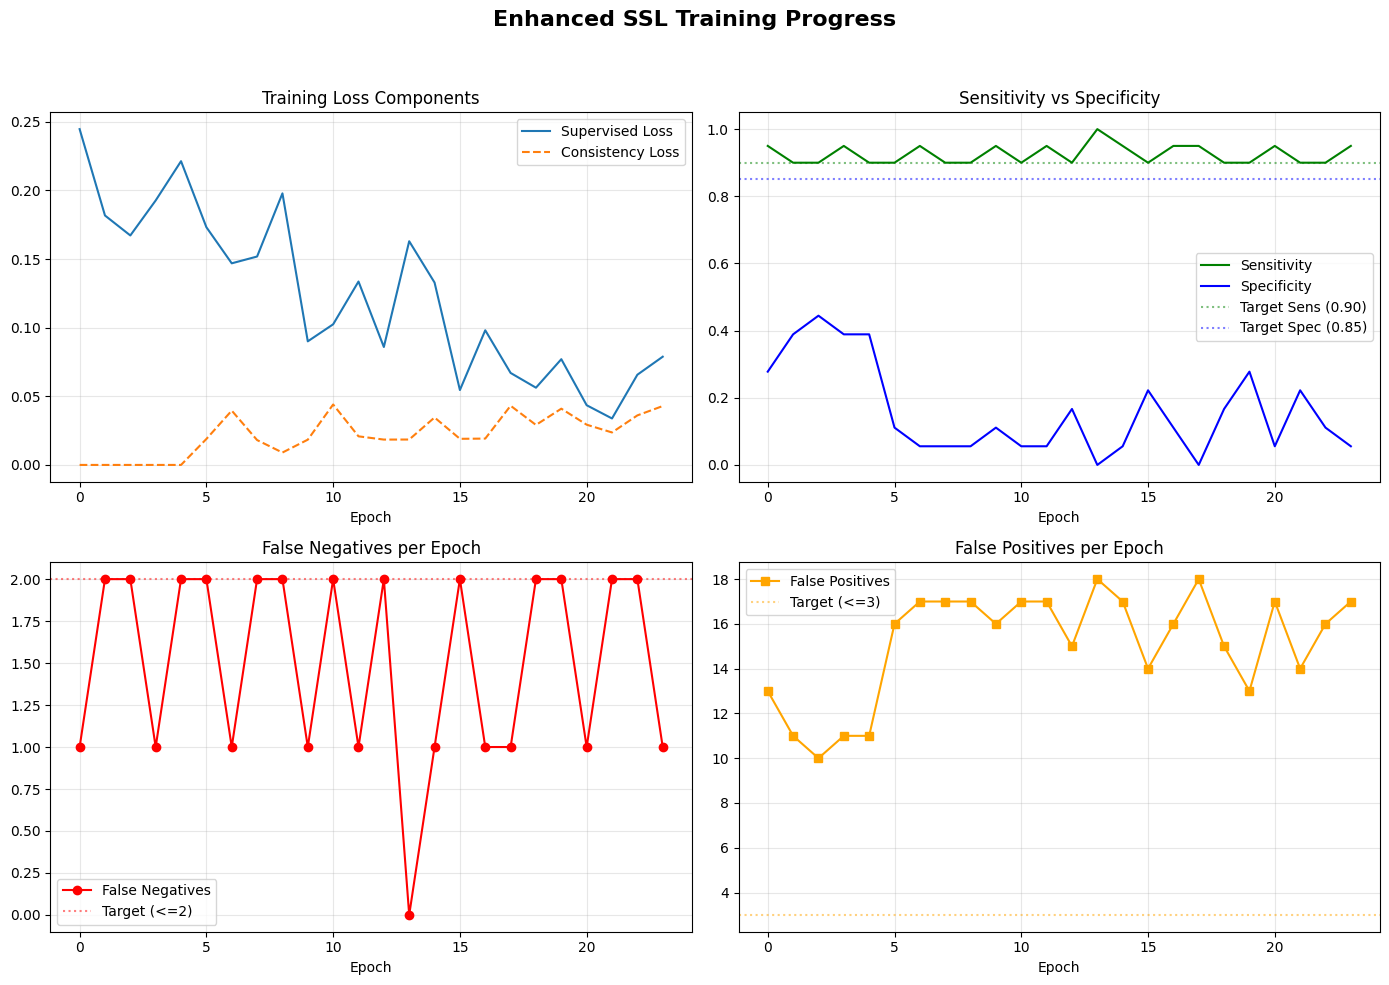


TRAINING ENSEMBLE MODEL 2/3

Loaded 190 labeled (Counter({1: 98, 0: 92})) and 6377 unlabeled images.
Skipping key classifier.1.weight, checkpoint shape torch.Size([256, 1280]), model shape torch.Size([512, 1280])
Skipping key classifier.1.bias, checkpoint shape torch.Size([256]), model shape torch.Size([512])

ENHANCED SSL TRAINING WITH AGGRESSIVE OPTIMIZATION


Epoch 1: 100%|██████████| 10/10 [00:36<00:00,  3.69s/it, sup_loss=0.190, cons_loss=0.000]



Epoch 1/60 | Sens: 1.000, Spec: 0.389, FN: 0, FP: 11, Thr: 0.395
  ✓ Saved best model (FN: 0, FP: 11, Score: 11)


Epoch 2: 100%|██████████| 10/10 [00:34<00:00,  3.44s/it, sup_loss=0.102, cons_loss=0.000]



Epoch 2/60 | Sens: 0.900, Spec: 0.611, FN: 2, FP: 7, Thr: 0.385


Epoch 3: 100%|██████████| 10/10 [00:38<00:00,  3.82s/it, sup_loss=0.286, cons_loss=0.000]



Epoch 3/60 | Sens: 0.900, Spec: 0.556, FN: 2, FP: 8, Thr: 0.355


Epoch 4: 100%|██████████| 10/10 [00:35<00:00,  3.55s/it, sup_loss=0.184, cons_loss=0.000]



Epoch 4/60 | Sens: 1.000, Spec: 0.333, FN: 0, FP: 12, Thr: 0.200


Epoch 5: 100%|██████████| 10/10 [00:38<00:00,  3.84s/it, sup_loss=0.177, cons_loss=0.000]



Epoch 5/60 | Sens: 1.000, Spec: 0.556, FN: 0, FP: 8, Thr: 0.270
  ✓ Saved best model (FN: 0, FP: 8, Score: 8)


Epoch 6: 100%|██████████| 10/10 [01:55<00:00, 11.52s/it, sup_loss=0.195, cons_loss=0.024]



Epoch 6/60 | Sens: 0.900, Spec: 0.278, FN: 2, FP: 13, Thr: 0.215


Epoch 7: 100%|██████████| 10/10 [01:58<00:00, 11.88s/it, sup_loss=0.087, cons_loss=0.002]



Epoch 7/60 | Sens: 0.900, Spec: 0.333, FN: 2, FP: 12, Thr: 0.250


Epoch 8: 100%|██████████| 10/10 [01:53<00:00, 11.38s/it, sup_loss=0.473, cons_loss=0.005]



Epoch 8/60 | Sens: 0.900, Spec: 0.333, FN: 2, FP: 12, Thr: 0.245


Epoch 9: 100%|██████████| 10/10 [01:53<00:00, 11.33s/it, sup_loss=0.087, cons_loss=0.010]



Epoch 9/60 | Sens: 0.950, Spec: 0.278, FN: 1, FP: 13, Thr: 0.185


Epoch 10: 100%|██████████| 10/10 [01:56<00:00, 11.67s/it, sup_loss=0.178, cons_loss=0.013]



Epoch 10/60 | Sens: 0.950, Spec: 0.333, FN: 1, FP: 12, Thr: 0.270


Epoch 11: 100%|██████████| 10/10 [01:56<00:00, 11.69s/it, sup_loss=0.039, cons_loss=0.007]



Epoch 11/60 | Sens: 0.900, Spec: 0.333, FN: 2, FP: 12, Thr: 0.265


Epoch 12: 100%|██████████| 10/10 [01:55<00:00, 11.59s/it, sup_loss=0.039, cons_loss=0.004]



Epoch 12/60 | Sens: 0.900, Spec: 0.278, FN: 2, FP: 13, Thr: 0.175


Epoch 13: 100%|██████████| 10/10 [01:59<00:00, 11.93s/it, sup_loss=0.236, cons_loss=0.008]



Epoch 13/60 | Sens: 0.900, Spec: 0.333, FN: 2, FP: 12, Thr: 0.235


Epoch 14: 100%|██████████| 10/10 [01:55<00:00, 11.50s/it, sup_loss=0.018, cons_loss=0.013]



Epoch 14/60 | Sens: 0.950, Spec: 0.278, FN: 1, FP: 13, Thr: 0.150


Epoch 15: 100%|██████████| 10/10 [01:54<00:00, 11.41s/it, sup_loss=0.039, cons_loss=0.010]



Epoch 15/60 | Sens: 0.950, Spec: 0.222, FN: 1, FP: 14, Thr: 0.135


Epoch 16: 100%|██████████| 10/10 [01:55<00:00, 11.55s/it, sup_loss=0.276, cons_loss=0.013]



Epoch 16/60 | Sens: 0.950, Spec: 0.278, FN: 1, FP: 13, Thr: 0.135


Epoch 17: 100%|██████████| 10/10 [01:58<00:00, 11.89s/it, sup_loss=0.255, cons_loss=0.009]



Epoch 17/60 | Sens: 0.950, Spec: 0.333, FN: 1, FP: 12, Thr: 0.145


Epoch 18: 100%|██████████| 10/10 [01:56<00:00, 11.68s/it, sup_loss=0.279, cons_loss=0.012]



Epoch 18/60 | Sens: 0.900, Spec: 0.278, FN: 2, FP: 13, Thr: 0.135


Epoch 19: 100%|██████████| 10/10 [02:00<00:00, 12.03s/it, sup_loss=0.635, cons_loss=0.008]



Epoch 19/60 | Sens: 0.900, Spec: 0.222, FN: 2, FP: 14, Thr: 0.080


Epoch 20: 100%|██████████| 10/10 [02:08<00:00, 12.85s/it, sup_loss=0.465, cons_loss=0.007]



Epoch 20/60 | Sens: 0.950, Spec: 0.278, FN: 1, FP: 13, Thr: 0.110


Epoch 21: 100%|██████████| 10/10 [02:03<00:00, 12.35s/it, sup_loss=0.052, cons_loss=0.014]



Epoch 21/60 | Sens: 0.900, Spec: 0.500, FN: 2, FP: 9, Thr: 0.135


Epoch 22: 100%|██████████| 10/10 [02:04<00:00, 12.50s/it, sup_loss=0.146, cons_loss=0.023]



Epoch 22/60 | Sens: 0.950, Spec: 0.444, FN: 1, FP: 10, Thr: 0.145


Epoch 23: 100%|██████████| 10/10 [02:19<00:00, 13.96s/it, sup_loss=0.128, cons_loss=0.014]



Epoch 23/60 | Sens: 0.900, Spec: 0.389, FN: 2, FP: 11, Thr: 0.125


Epoch 24: 100%|██████████| 10/10 [02:13<00:00, 13.36s/it, sup_loss=0.012, cons_loss=0.005]



Epoch 24/60 | Sens: 0.900, Spec: 0.500, FN: 2, FP: 9, Thr: 0.125


Epoch 25: 100%|██████████| 10/10 [02:06<00:00, 12.61s/it, sup_loss=0.090, cons_loss=0.006]



Epoch 25/60 | Sens: 0.950, Spec: 0.389, FN: 1, FP: 11, Thr: 0.110

Early stopping!

TRAINING COMPLETED
Best Results: {'sensitivity': np.float64(1.0), 'specificity': np.float64(0.5555555555555556), 'false_negatives': np.int64(0), 'false_positives': np.int64(8), 'is_clinically_acceptable': np.False_}


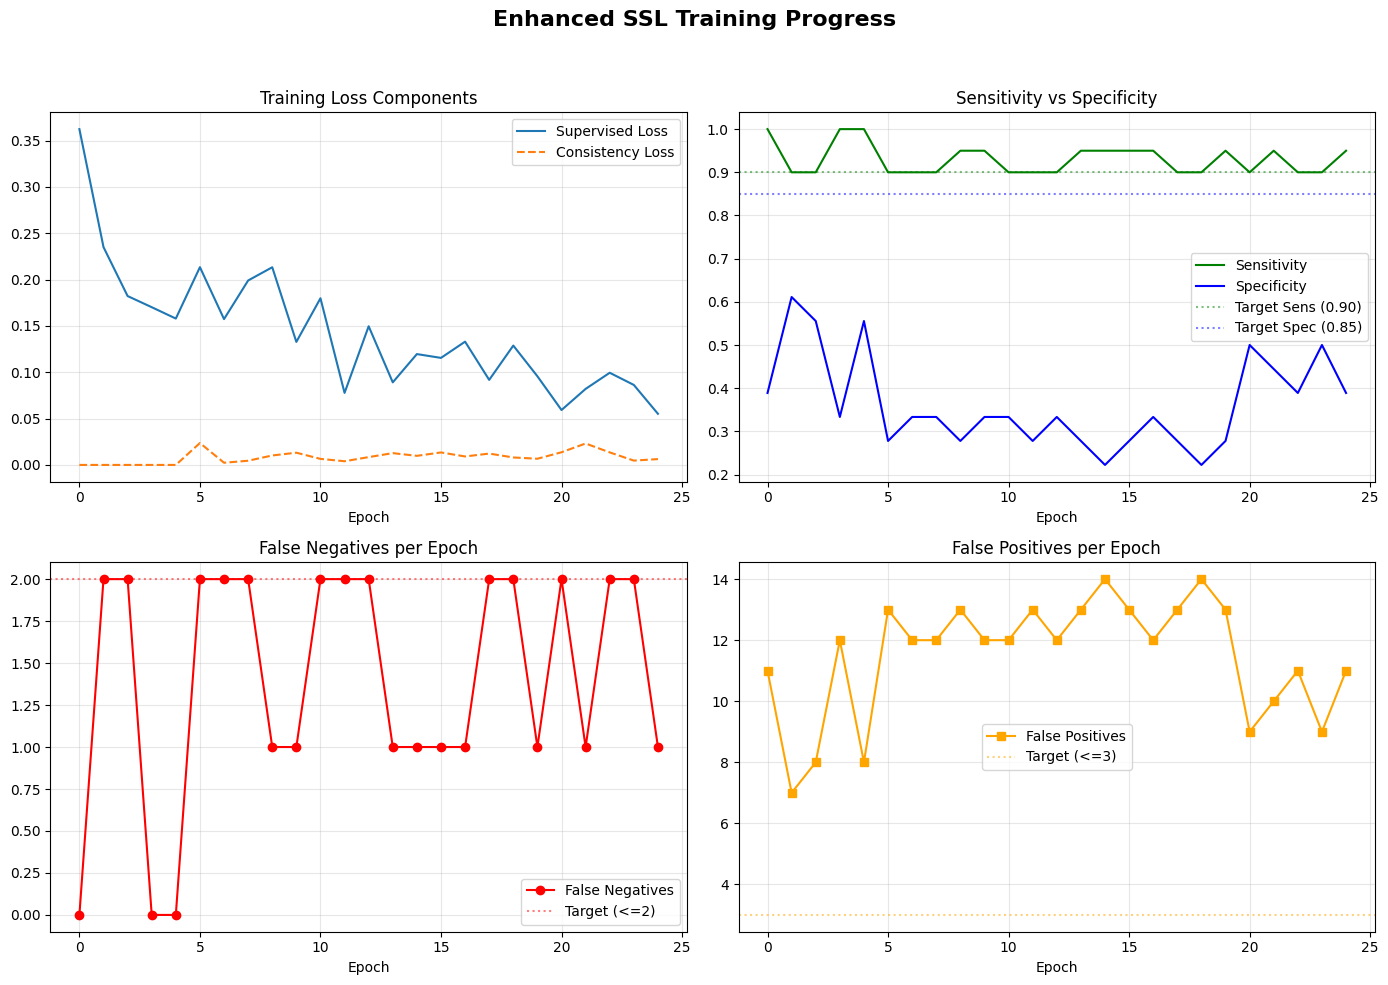


TRAINING ENSEMBLE MODEL 3/3

Loaded 190 labeled (Counter({1: 98, 0: 92})) and 6377 unlabeled images.
Skipping key classifier.1.weight, checkpoint shape torch.Size([256, 1280]), model shape torch.Size([512, 1280])
Skipping key classifier.1.bias, checkpoint shape torch.Size([256]), model shape torch.Size([512])

ENHANCED SSL TRAINING WITH AGGRESSIVE OPTIMIZATION


Epoch 1: 100%|██████████| 10/10 [00:40<00:00,  4.04s/it, sup_loss=0.054, cons_loss=0.000]



Epoch 1/60 | Sens: 0.900, Spec: 0.111, FN: 2, FP: 16, Thr: 0.420
  ✓ Saved best model (FN: 2, FP: 16, Score: 26)


Epoch 2: 100%|██████████| 10/10 [00:38<00:00,  3.81s/it, sup_loss=0.180, cons_loss=0.000]



Epoch 2/60 | Sens: 1.000, Spec: 0.000, FN: 0, FP: 18, Thr: 0.010
  ✓ Saved best model (FN: 0, FP: 18, Score: 18)


Epoch 3: 100%|██████████| 10/10 [00:38<00:00,  3.84s/it, sup_loss=0.080, cons_loss=0.000]



Epoch 3/60 | Sens: 0.900, Spec: 0.278, FN: 2, FP: 13, Thr: 0.350


Epoch 4: 100%|██████████| 10/10 [00:37<00:00,  3.70s/it, sup_loss=0.027, cons_loss=0.000]



Epoch 4/60 | Sens: 0.950, Spec: 0.056, FN: 1, FP: 17, Thr: 0.175


Epoch 5: 100%|██████████| 10/10 [00:37<00:00,  3.72s/it, sup_loss=0.051, cons_loss=0.000]



Epoch 5/60 | Sens: 0.900, Spec: 0.167, FN: 2, FP: 15, Thr: 0.270


Epoch 6: 100%|██████████| 10/10 [02:05<00:00, 12.57s/it, sup_loss=0.023, cons_loss=0.021]



Epoch 6/60 | Sens: 0.900, Spec: 0.278, FN: 2, FP: 13, Thr: 0.255


Epoch 7: 100%|██████████| 10/10 [02:09<00:00, 12.91s/it, sup_loss=0.063, cons_loss=0.015]



Epoch 7/60 | Sens: 0.950, Spec: 0.222, FN: 1, FP: 14, Thr: 0.180


Epoch 8: 100%|██████████| 10/10 [02:12<00:00, 13.22s/it, sup_loss=0.008, cons_loss=0.012]



Epoch 8/60 | Sens: 0.950, Spec: 0.222, FN: 1, FP: 14, Thr: 0.165


Epoch 9: 100%|██████████| 10/10 [02:13<00:00, 13.35s/it, sup_loss=0.252, cons_loss=0.035]



Epoch 9/60 | Sens: 0.950, Spec: 0.278, FN: 1, FP: 13, Thr: 0.240


Epoch 10: 100%|██████████| 10/10 [02:07<00:00, 12.73s/it, sup_loss=0.026, cons_loss=0.007]



Epoch 10/60 | Sens: 0.950, Spec: 0.278, FN: 1, FP: 13, Thr: 0.240


Epoch 11: 100%|██████████| 10/10 [02:03<00:00, 12.34s/it, sup_loss=0.181, cons_loss=0.011]



Epoch 11/60 | Sens: 0.950, Spec: 0.278, FN: 1, FP: 13, Thr: 0.235


Epoch 12: 100%|██████████| 10/10 [02:12<00:00, 13.24s/it, sup_loss=0.053, cons_loss=0.016]



Epoch 12/60 | Sens: 0.950, Spec: 0.278, FN: 1, FP: 13, Thr: 0.190


Epoch 13: 100%|██████████| 10/10 [02:03<00:00, 12.36s/it, sup_loss=0.003, cons_loss=0.022]



Epoch 13/60 | Sens: 0.900, Spec: 0.333, FN: 2, FP: 12, Thr: 0.275


Epoch 14: 100%|██████████| 10/10 [02:16<00:00, 13.65s/it, sup_loss=0.040, cons_loss=0.008]



Epoch 14/60 | Sens: 0.950, Spec: 0.278, FN: 1, FP: 13, Thr: 0.190


Epoch 15: 100%|██████████| 10/10 [02:26<00:00, 14.69s/it, sup_loss=0.203, cons_loss=0.019]



Epoch 15/60 | Sens: 0.950, Spec: 0.278, FN: 1, FP: 13, Thr: 0.165


Epoch 16: 100%|██████████| 10/10 [03:27<00:00, 20.73s/it, sup_loss=0.017, cons_loss=0.015]



Epoch 16/60 | Sens: 0.950, Spec: 0.278, FN: 1, FP: 13, Thr: 0.145


Epoch 17: 100%|██████████| 10/10 [02:22<00:00, 14.22s/it, sup_loss=0.043, cons_loss=0.008]



Epoch 17/60 | Sens: 0.900, Spec: 0.333, FN: 2, FP: 12, Thr: 0.185


Epoch 18: 100%|██████████| 10/10 [02:13<00:00, 13.35s/it, sup_loss=0.020, cons_loss=0.011]



Epoch 18/60 | Sens: 0.900, Spec: 0.278, FN: 2, FP: 13, Thr: 0.170


Epoch 19: 100%|██████████| 10/10 [02:01<00:00, 12.12s/it, sup_loss=0.085, cons_loss=0.012]



Epoch 19/60 | Sens: 0.900, Spec: 0.278, FN: 2, FP: 13, Thr: 0.125


Epoch 20: 100%|██████████| 10/10 [02:01<00:00, 12.12s/it, sup_loss=0.082, cons_loss=0.025]



Epoch 20/60 | Sens: 0.900, Spec: 0.389, FN: 2, FP: 11, Thr: 0.285


Epoch 21: 100%|██████████| 10/10 [01:58<00:00, 11.85s/it, sup_loss=0.068, cons_loss=0.017]



Epoch 21/60 | Sens: 0.900, Spec: 0.278, FN: 2, FP: 13, Thr: 0.145


Epoch 22: 100%|██████████| 10/10 [02:30<00:00, 15.03s/it, sup_loss=0.013, cons_loss=0.005]



Epoch 22/60 | Sens: 0.950, Spec: 0.278, FN: 1, FP: 13, Thr: 0.145

Early stopping!

TRAINING COMPLETED
Best Results: {'sensitivity': np.float64(1.0), 'specificity': np.float64(0.0), 'false_negatives': np.int64(0), 'false_positives': np.int64(18), 'is_clinically_acceptable': np.False_}


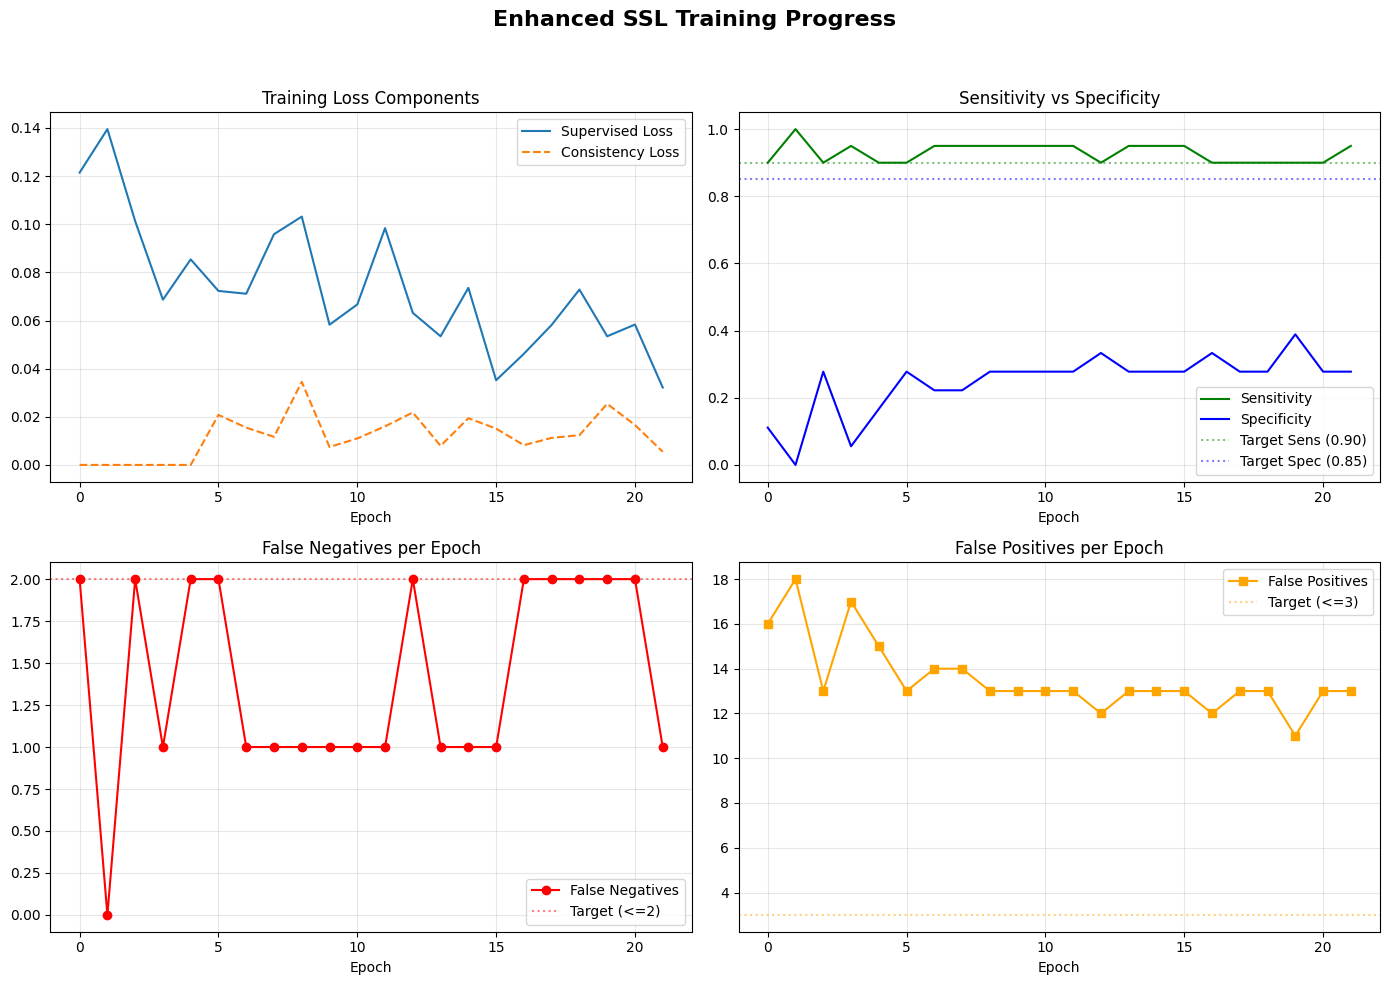

Loaded 190 labeled (Counter({1: 98, 0: 92})) and 6377 unlabeled images.


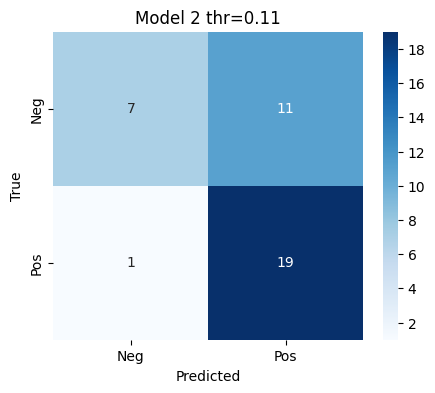


📊 Performance for Model 2 (thr=0.11):
Accuracy: 0.684
Sensitivity: 0.950
Specificity: 0.389
Precision: 0.633
Auc: 0.717


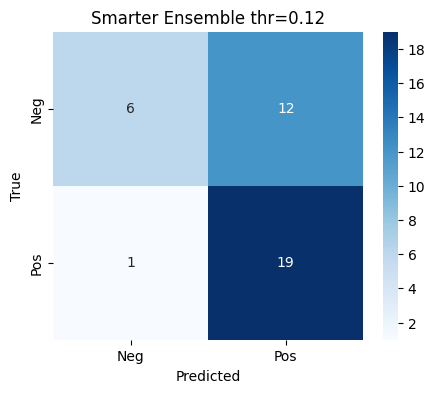


📊 Performance for Smarter Ensemble (thr=0.12):
Accuracy: 0.658
Sensitivity: 0.950
Specificity: 0.333
Precision: 0.613
Auc: 0.703

================= COMPARISON =================
Model 2 - Sensitivity: 0.950, Specificity: 0.389, Accuracy: 0.684
Smarter Ensemble - Sensitivity: 0.950, Specificity: 0.333, Accuracy: 0.658

✅ Recommendation: Use Model 2.
💾 Model 2 saved to best_model.pth

Final recommended model metrics:
{'accuracy': 0.6842105263157895, 'sensitivity': 0.95, 'specificity': 0.3888888888888889, 'precision': 0.6333333333333333, 'auc': 0.7166666666666667}


In [ ]:
# ============================================================
# 11. Main Execution
# ============================================================
def convert_numpy_to_python(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    if isinstance(obj, np.floating):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    if isinstance(obj, dict):
        return {k: convert_numpy_to_python(v) for k, v in obj.items()}
    if isinstance(obj, list):
        return [convert_numpy_to_python(item) for item in obj]
    return obj

def evaluate_pipeline(models, val_loader, device, save_path="best_model.pth"):
    """
    Auto search thresholds for Model 2 and Smarter Ensemble,
    choose model with higher sensitivity, save checkpoint with threshold.
    """

    # collect ground truth labels
    y_true = []
    for _, (x, y) in enumerate(val_loader):
        y_true.extend(y.numpy())
    y_true = np.array(y_true)

    # Model 2 probabilities
    model2 = models[1]
    model2.eval()
    probs2 = []
    with torch.no_grad():
        for x, _ in val_loader:
            x = x.to(device)
            out = model2(x)
            if out.dim() == 1 or out.shape[1] == 1:
                probs_batch = torch.stack([1 - torch.sigmoid(out).unsqueeze(1),
                                           torch.sigmoid(out).unsqueeze(1)], dim=1).squeeze(2)
            else:
                probs_batch = torch.softmax(out, dim=1)
            probs2.append(probs_batch.cpu())
    probs2 = torch.cat(probs2, dim=0).numpy()

    # search threshold for Model 2
    best_thr_m2, best_metrics_m2 = None, None
    best_sens = -1
    for thr in np.arange(0.05, 0.95, 0.01):
        preds = (probs2[:, 1] >= thr).astype(int)
        rep = classification_report(y_true, preds, output_dict=True, zero_division=0)
        sens = rep["1"]["recall"]
        spec = rep["0"]["recall"]
        acc = rep["accuracy"]
        auc = roc_auc_score(y_true, probs2[:, 1]) if len(np.unique(y_true)) > 1 else float("nan")
        if sens > best_sens or (sens == best_sens and (best_metrics_m2 is None or spec > best_metrics_m2["specificity"])):
            best_sens = sens
            best_thr_m2 = thr
            best_metrics_m2 = {"accuracy": acc, "sensitivity": sens, "specificity": spec, "precision": rep["1"]["precision"], "auc": auc}

    preds2 = (probs2[:, 1] >= best_thr_m2).astype(int)
    plot_confusion_matrix(y_true, preds2, title=f"Model 2 thr={best_thr_m2:.2f}")

    print(f"\n📊 Performance for Model 2 (thr={best_thr_m2:.2f}):")
    for k, v in best_metrics_m2.items():
        print(f"{k.capitalize()}: {v:.3f}")

    # Smarter Ensemble probabilities and threshold search
    selected_models = [models[0], models[1]]
    weights = [0.3, 0.7]
    _, probs_ens = smarter_ensemble(selected_models, val_loader, device, weights=weights, threshold=0.5, return_probs=True)
    probs_ens = probs_ens.numpy()

    best_thr_ens, best_metrics_ens = None, None
    best_sens = -1
    for thr in np.arange(0.05, 0.95, 0.01):
        preds = (probs_ens[:, 1] >= thr).astype(int)
        rep = classification_report(y_true, preds, output_dict=True, zero_division=0)
        sens = rep["1"]["recall"]
        spec = rep["0"]["recall"]
        acc = rep["accuracy"]
        auc = roc_auc_score(y_true, probs_ens[:, 1]) if len(np.unique(y_true)) > 1 else float("nan")
        if sens > best_sens or (sens == best_sens and (best_metrics_ens is None or spec > best_metrics_ens["specificity"])):
            best_sens = sens
            best_thr_ens = thr
            best_metrics_ens = {"accuracy": acc, "sensitivity": sens, "specificity": spec, "precision": rep["1"]["precision"], "auc": auc}

    preds_ens = (probs_ens[:, 1] >= best_thr_ens).astype(int)
    plot_confusion_matrix(y_true, preds_ens, title=f"Smarter Ensemble thr={best_thr_ens:.2f}")

    print(f"\n📊 Performance for Smarter Ensemble (thr={best_thr_ens:.2f}):")
    for k, v in best_metrics_ens.items():
        print(f"{k.capitalize()}: {v:.3f}")

    # Choose winner by higher sensitivity, ties broken by specificity
    print("\n================= COMPARISON =================")
    print(f"Model 2 - Sensitivity: {best_metrics_m2['sensitivity']:.3f}, Specificity: {best_metrics_m2['specificity']:.3f}, Accuracy: {best_metrics_m2['accuracy']:.3f}")
    print(f"Smarter Ensemble - Sensitivity: {best_metrics_ens['sensitivity']:.3f}, Specificity: {best_metrics_ens['specificity']:.3f}, Accuracy: {best_metrics_ens['accuracy']:.3f}")

    if best_metrics_ens["sensitivity"] > best_metrics_m2["sensitivity"]:
        print("\n✅ Recommendation: Use Smarter Ensemble.")
        torch.save({
            "model1_state_dict": selected_models[0].state_dict(),
            "model2_state_dict": selected_models[1].state_dict(),
            "weights": weights,
            "threshold": best_thr_ens,
            "metrics": best_metrics_ens
        }, save_path)
        print(f"💾 Smarter Ensemble saved to {save_path}")
        return best_metrics_ens
    else:
        print("\n✅ Recommendation: Use Model 2.")
        torch.save({
            "model_state_dict": model2.state_dict(),
            "threshold": best_thr_m2,
            "metrics": best_metrics_m2
        }, save_path)
        print(f"💾 Model 2 saved to {save_path}")
        return best_metrics_m2

def main_single_model():
    print("="*60)
    print("ENHANCED SSL TRAINING - SINGLE MODEL")
    print("="*60)

    ARTIFACTS_DIR = Path("artifacts")
    model = EnhancedSSLEfficientNet(num_classes=2, dropout_rate=0.4)
    trainer = EnhancedTrainer(model, device=device, ssl_weight=0.5, confidence_thresh=0.97)

    labeled_loader, val_loader, unlabeled_loader = build_loaders(batch_size_labeled=16, batch_size_unlabeled=32)
    history = trainer.train(labeled_loader, unlabeled_loader, val_loader, epochs=60, warmup_epochs=5)

    plot_training_history(history)

    history_serializable = convert_numpy_to_python(history)
    with open(ARTIFACTS_DIR / "enhanced_training_history.json", "w") as f:
        json.dump(history_serializable, f, indent=2)

    return trainer, history

def main_ensemble():
    models, trainers = train_ensemble(n_models=3)

    # Build validation loader explicitly
    _, val_dataset, _, _ = load_and_prepare_data()
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    best_metrics = evaluate_pipeline(models, val_loader, device, save_path="artifacts/best_model.pth")
    return models, trainers, best_metrics

if __name__ == "__main__":
    USE_ENSEMBLE = True

    if USE_ENSEMBLE:
        models, trainers, metrics = main_ensemble()
        print("\nFinal recommended model metrics:")
        print(metrics)
    else:
        trainer, history = main_single_model()
        print("Single model training complete")